In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time
from numba import jit, prange
from multiprocessing import Pool, cpu_count
import pandas as pd 
from tqdm import tqdm

In [2]:
def hot_config(L):
    return np.random.choice([-1, 1], size=(L, L))

def cold_config(L):
    return np.ones((L, L))

@jit
def E_dimensionless(config, L):
    total_energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i, j]
            nb = config[(i + 1) % L, j] + config[i, (j + 1) % L] + config[(i - 1) % L, j] + config[i, (j - 1) % L]
            total_energy += -J * nb * S - H * nb
    return total_energy / 2.


@jit
def MC_step(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm
    '''
    L = len(config)
    for i in range(L*L):
        a = np.random.randint(0, L)  # looping over i & j therefore use a & b
        b = np.random.randint(0, L)
        sigma = config[a, b]
        neighbors = config[(a + 1) % L, b] + config[a, (b + 1) % L] + config[(a - 1) % L, b] + config[
            a, (b - 1) % L]
        del_E = 2 * J * sigma * neighbors + 2 * H * sigma
        
        if (del_E < 0) or (rand() < np.exp(-del_E * beta)):
            config[a, b] = -sigma
        

@jit
def calcul_energy_mag_C_X(config, L, eqSteps, err_runs):
    # L is the length of the lattice

    nt = 100  # number of temperature points
    mcSteps = 1000

    T_c = 2 / np.log(1 + np.sqrt(2))

    # the number of MC sweeps for equilibrium should be at least equal to the number of MC sweeps for equilibrium

    # initialization of all variables
    T = np.linspace(1., 7., nt)
    C_theoric, M_theoric = np.zeros(nt), np.zeros(nt)
    delta_E, delta_M, delta_C, delta_X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    n1 = 1.0 / (mcSteps * L * L)
    n2 = 1.0 / (mcSteps * mcSteps * L * L)  # n1 and n2 will be use to compute the mean value and the # by sites
    # of E and E^2

    Energies = np.zeros((len(T), 2))
    Magnetizations = np.zeros((len(T), 2))
    SpecificHeats = np.zeros((len(T), 2))
    Susceptibilities = np.zeros((len(T), 2))

    for t in range(nt):
        # initialize total energy and mag
        beta = 1. / T[t]
        # evolve the system to equilibrium
        for i in range(eqSteps):
            MC_step(config, beta)
        # list of ten macroscopic properties
        Ez = []
        Cz = []
        Mz = []
        Xz = []

        for j in range(err_runs):
            E = E_squared = M = M_squared = 0
            for i in range(mcSteps):
                MC_step(config, beta)
                energy = E_dimensionless(config, L)  # calculate the energy at time stamp
                mag = abs(np.sum(config))  # calculate the abs total mag. at time stamp

                # sum up total energy and mag after each time steps

                E = E + energy
                E_squared = E_squared + energy ** 2
                M = M + mag
                M_squared = M_squared + mag ** 2

            # mean (divide by total time steps)

            E_mean = E / mcSteps
            E_squared_mean = E_squared / mcSteps
            M_mean = M / (mcSteps * (L ** 2))
            M_squared_mean = M_squared / (mcSteps * (L ** 2))

            # calculate macroscopic properties (divide by # sites) and append

            Energy = E_mean / (L ** 2)
            SpecificHeat = beta ** 2 * (E_squared_mean - E_mean ** 2) / L ** 2
            Magnetization = M_mean
            Susceptibility = beta * (M_squared_mean - M_mean ** 2) * (L ** 2)

            Ez.append(Energy)
            Cz.append(SpecificHeat)
            Mz.append(Magnetization)
            Xz.append(Susceptibility)

        Energies[t, 0] = np.mean(np.array(Ez))
        Energies[t, 1] = np.std(np.array(Ez))

        Magnetizations[t, 0] = np.mean(np.array(Mz))
        Magnetizations[t, 1] = np.std(np.array(Mz))

        SpecificHeats[t, 0] = np.mean(np.array(Cz))
        SpecificHeats[t, 1] = np.std(np.array(Cz))

        Susceptibilities[t, 0] = np.mean(np.array(Xz))
        Susceptibilities[t, 1] = np.std(np.array(Xz))

        if T[t] - T_c >= 0:
            C_theoric[t] = 0
        else:
            M_theoric[t] = pow(1 - pow(np.sinh(2 * beta), -4), 1 / 8)

        coeff = np.log(1 + np.sqrt(2))
        if T[t] - T_c >= 0:
            C_theoric[t] = 0
        else:
            C_theoric[t] = (2.0 / np.pi) * (coeff ** 2) * (
                    -np.log(1 - T[t] / T_c) + np.log(1.0 / coeff) - (1 + np.pi / 4))

    return T, Energies, Magnetizations, SpecificHeats, Susceptibilities, M_theoric, C_theoric



In [3]:
def phase_transition(T):
# L is the length of the lattice

    # number of temperature points
    eqSteps = 50000
    #eqSteps = 5000
    mcSteps = 1000
    err_runs = 100
    coeff = np.log(1 + np.sqrt(2))

    T_c = 2 / np.log(1 + np.sqrt(2))

    # the number of MC sweeps for equilibrium should be at least equal to the number of MC sweeps for equilibrium

    # initialization of all variables
   
    E, E_std = 0, 0
    M, M_std, M_th = 0, 0, 0
    C, C_std, C_th = 0, 0, 0
    X, X_std = 0, 0

    # initialize total energy and mag
    beta = 1. / T
    # evolve the system to equilibrium
    for i in range(eqSteps):
        MC_step(config, beta)
    # list of ten macroscopic properties
    Ez = []
    Cz = []
    Mz = []
    Xz = []

    for j in range(err_runs):
        E = np.zeros(mcSteps)
        M = np.zeros(mcSteps)
        for i in range(mcSteps):
            MC_step(config, beta)
            E[i] = E_dimensionless(config, L)  # calculate the energy at time stamp
            M[i] = abs(np.mean(config))  # calculate the abs total mag. at time stamp


        # calculate macroscopic properties (divide by # sites) and append
        Energy = E.mean() / L ** 2
        SpecificHeat = beta ** 2 * E.var() / L**2
        Magnetization = M.mean()
        Susceptibility = beta * M.var() * (L ** 2)

        Ez.append(Energy)
        Cz.append(SpecificHeat)
        Mz.append(Magnetization)
        Xz.append(Susceptibility)

    E = np.mean(np.array(Ez))
    E_std = np.std(np.array(Ez))

    M = np.mean(np.array(Mz))
    M_std = np.std(np.array(Mz))

    C = np.mean(np.array(Cz))
    C_std = np.std(np.array(Cz))

    X = np.mean(np.array(Xz))
    X_std = np.std(np.array(Xz))
    
    if T - T_c >= 0:
        C_th = 0
        M_th = 0
    else:
        M_th = pow(1 - pow(np.sinh(2 * beta), -4), 1 / 8)
        C_th = (2.0 / np.pi) * (coeff ** 2) * (
                -np.log(1 - T / T_c) + np.log(1.0 / coeff) - (1 + np.pi / 4))
    
    return np.array([T, E, E_std, M, M_std, M_th, C, C_std, C_th, X, X_std])

## Transition Phase

In [4]:
def sim():
    p = Pool(cpu_count()- 6)
    nt = 100
    T = np.linspace(1., 7., nt)
    res = p.map(phase_transition, T)
    p.close()
    return res

In [ ]:
%%time

L = 16
m = cold_config(L)
T, E, M, C, Susc, M_t, C_t = calcul_energy_mag_C_X(m, L, 5000, 100)

In [15]:
%%time
L = 16
J = 1
H = 0
config = hot_config(L)
res = sim()

CPU times: user 0 ns, sys: 156 ms, total: 156 ms
Wall time: 1min 8s


In [16]:
import matplotlib.gridspec as gridspec
def plot_th(df):
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(10,5))
    for ax, name in zip(axs.flat, ['M', 'C']):
        ax.errorbar(df['Temp'], df[f'{name}'], yerr=df[f'{name}_std'], label='sim')
        ax.plot(df['Temp'], df[f'{name}_th'], label='Th')
        ax.set_title(f'{name} plot')
        ax.legend()

def plot_sim(df):
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(10,5))
    for ax, name in zip(axs.flat, ['E', 'X']):
        ax.errorbar(df['Temp'], df[f'{name}'], yerr=df[f'{name}_std'], label='sim')
        ax.set_title(f'{name} plot')
        ax.legend()

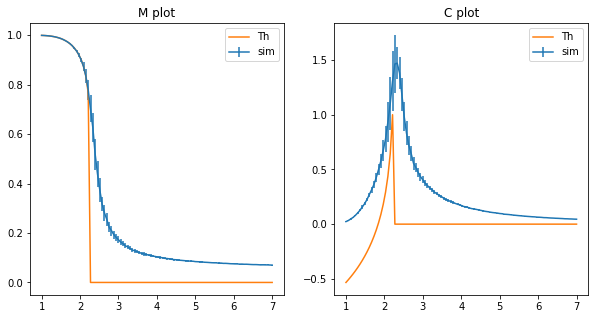

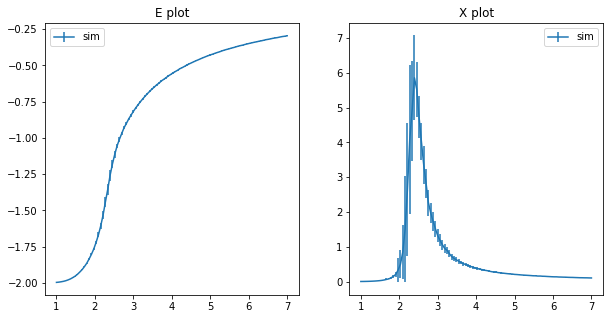

In [17]:
df = pd.DataFrame(res, columns=['Temp', 'E', 'E_std', 'M', 'M_std', 'M_th', 'C', 'C_std', 'C_th', 'X', 'X_std'])
plot_th(df)
plot_sim(df)

In [29]:
df.to_csv(f'./Results/Hot start/B0/{L}x{L}_block_100err.csv', index=False)

In [ ]:
df

## Video Maker

100%|██████████| 50000/50000 [00:09<00:00, 5408.44it/s]
-0.0322265625 7


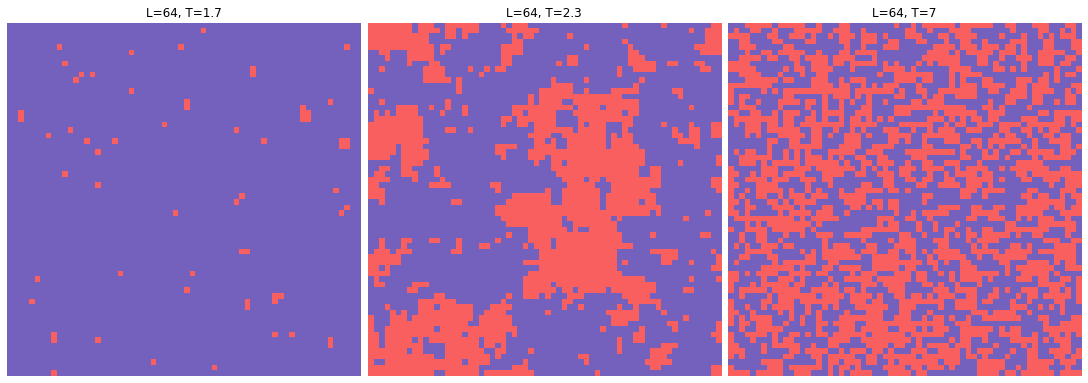

In [15]:
import matplotlib as mpl

# Rosso indica lo spin down, mentre il blu indica lo spin up
colors = [np.array([249, 95, 95])/255, np.array([115, 97, 189])/255]
cmap = mpl.colors.ListedColormap(colors)

L = 64
H = 0. 
J = 1
T = 4
config = hot_config(L)
Mz = [np.sum(config) / L ** 2]

fig = plt.figure(figsize=(15,5.48), constrained_layout=True)
gs = plt.GridSpec(1,3, figure=fig)

axs = []
for i, j in zip(gs, ['ax1', 'ax2', 'ax3']):
    globals()[j] = fig.add_subplot(i)
    axs.append(globals()[j])

for T, ax in zip([1.7, 2.3, 7], axs):
    for i in tqdm(range(50000)):
        MC_step(config, 1./T)
        
    print(np.mean(config), T)
    ax.matshow(config, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'L={L}, T={T}')

plt.savefig(f'phase_transition_lattice.png', facecolor='white', transparent=False)
            
    
    
    

## Autocorrelation

In [4]:
@jit
def MC_step_single(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm
    '''
    a = np.random.randint(0, L)  # looping over i & j therefore use a & b
    b = np.random.randint(0, L)
    sigma = config[a, b]
    neighbors = config[(a + 1) % L, b] + config[a, (b + 1) % L] + config[(a - 1) % L, b] + config[
        a, (b - 1) % L]
    del_E = -2 * J * (-sigma) * neighbors - H * (-sigma)
    
    if (del_E < 0) or (rand() < w[int(del_E + 8)]):
        sigma *= -1

    config[a, b] = sigma

In [11]:
from tqdm import tqdm

def corr(T):
    Mcsteps = 10000*(L**2)
    Mz = np.zeros(Mcsteps)

    for i in range(Mcsteps):
        MC_step_single(config, 1./T)
        Mz[i] = np.mean(config)
    return Mz


In [20]:
L = 16
H = 0.0
J = 1


#T = 1.5
config = hot_config(L)
w = np.zeros(18)
w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)
#m1 = corr(T)

#T = 1.5
config = hot_config(L)
w = np.zeros(18)
w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)
#m2 = corr(T)

T = 2.27
w = np.zeros(18)
w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)
config = hot_config(L)
m3 = corr(T)

#T = 4.
w = np.zeros(18)
w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)
config = hot_config(L)
#m4 = corr(T)

In [16]:
L = 16
H = 0. 
J = 1
config = hot_config(L)

Eq_time = 20 * L ** 2

T = 4.0 

w = np.zeros(18)
w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)

p2 = {1: np.zeros(100), -1: np.zeros(100)}
j = 0
for i in range(100 * Eq_time):
    MC_step_single(config, 1./T)
    if i % Eq_time == 0: 
        for s in [1, -1]:
            p2[s][j] = (config == s).sum()
        j += 1

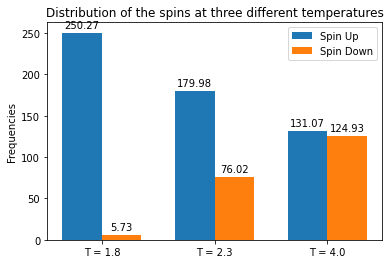

In [24]:
p[1].mean(), p[-1].mean(), p1[1].mean(), p1[-1].mean(), p2[1].mean(), p2[-1].mean(),

up = [p[1].mean(), p1[1][p1[1]>=50].mean(), p2[1].mean()]
down = [p[-1].mean(), p1[-1][p1[1]>=50].mean(), p2[-1].mean()]

labels = ['T = 1.8', 'T = 2.3', 'T = 4.0']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, up, width, label='Spin Up')
rects2 = ax.bar(x + width/2, down, width, label='Spin Down')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequencies')
ax.set_title('Distribution of the spins at three different temperatures')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

#fig.tight_layout()

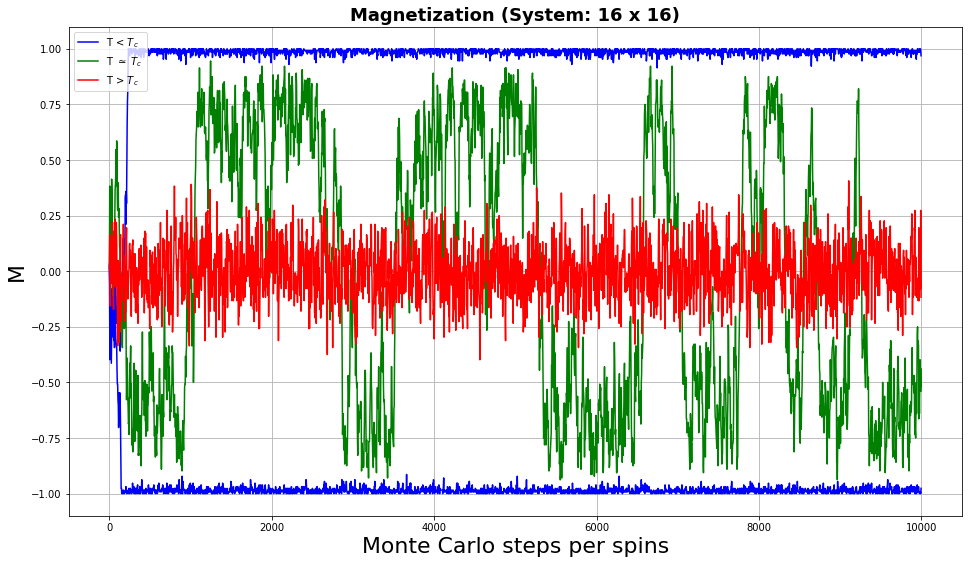

In [26]:
m3 = np.load('m_t24.npz')['m2']
m4 = np.load('m_t4.npz')['m3']


plt.figure(figsize=(16,9))
plt.rc('axes', labelsize=22)
t = np.arange(len(m2)) / L **2
plt.plot(t[::1000], m1[::1000], 'b')
plt.plot(t[::1000], m2[::1000], 'b', label=fr'T < $T_c$')
plt.plot(t[::1000], m3[::1000], 'g', label=fr'T $\simeq$ $T_c$')
plt.plot(t[::1000], m4[::1000], 'r', label=fr'T > $T_c$')
#plt.plot(m2[(t>8000) & (t<12000)][::1000], 'k', label=fr'T < $T_c$')
#plt.plot(m3[(t>8000) & (t<12000)][::1000], '--k', label=fr'T > $T_c$')
plt.ylabel('M')
plt.xlabel('Monte Carlo steps per spins')
plt.legend()
plt.title('Magnetization (System: 16 x 16)', fontsize=18, fontweight='bold')
plt.grid()
plt.savefig('traces.png', transparent=True)

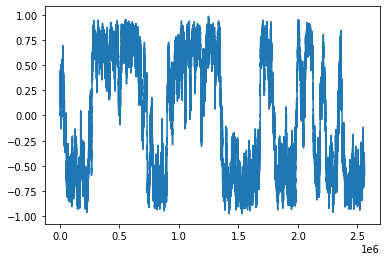

In [24]:
plt.plot(np.load('m_t24.npz')['m2'])

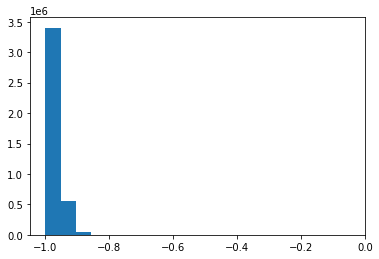

In [37]:
plt.hist(m1, bins=20);

'x, f = np.unique(m2, return_counts=True)\nzeros = np.zeros(len(x))\nplt.fill_between(x, f / f.sum(), zeros)\nx, f = np.unique(m3, return_counts=True)\nzeros = np.zeros(len(x))\nplt.fill_between(x, f / f.sum(), zeros)'

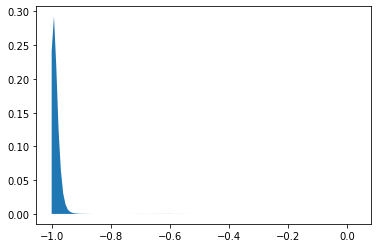

In [27]:
x, f = np.unique(m1, return_counts=True)
zeros = np.zeros(len(x))
plt.fill_between(x, f / f.sum(), zeros)
'''x, f = np.unique(m2, return_counts=True)
zeros = np.zeros(len(x))
plt.fill_between(x, f / f.sum(), zeros)
x, f = np.unique(m3, return_counts=True)
zeros = np.zeros(len(x))
plt.fill_between(x, f / f.sum(), zeros)'''

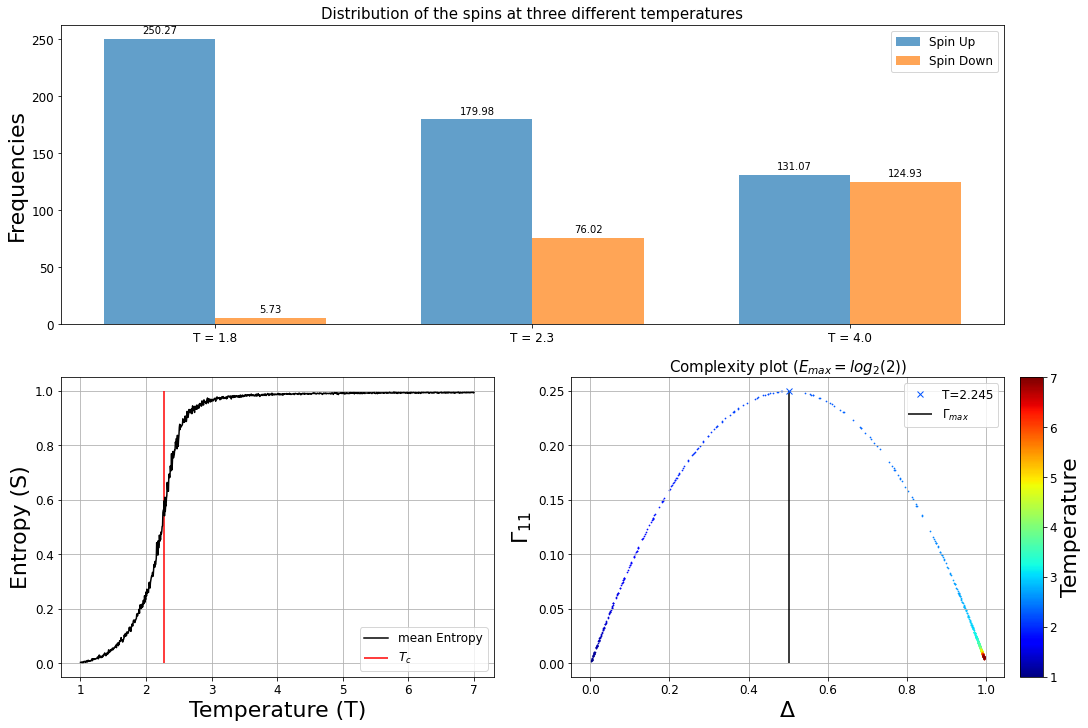

In [29]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm


SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 22

plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(15,10), constrained_layout=True)

gs = plt.GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


up = [p[1].mean(), p1[1][p1[1]>=50].mean(), p2[1].mean()]
down = [p[-1].mean(), p1[-1][p1[1]>=50].mean(), p2[-1].mean()]

labels = ['T = 1.8', 'T = 2.3', 'T = 4.0']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


rects1 = ax1.bar(x - width/2, up, width, label='Spin Up', alpha=0.7)
rects2 = ax1.bar(x + width/2, down, width, label='Spin Down', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Frequencies')
ax1.set_title('Distribution of the spins at three different temperatures', fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

T = np.load('entropy_from_lattice.npz')['T']
E = np.load('entropy_from_lattice.npz')['E']
delta = E / np.log2(2)
gamma = delta *  (1 - delta)

ax2.plot(T, E, 'k', label='mean Entropy')
ax2.vlines(2/(np.log(1+np.sqrt(2))), 0,1, color='r', label=r'$T_c$')
ax2.legend(loc='lower right')
ax2.set_xlabel('Temperature (T)')
ax2.set_ylabel('Entropy (S)')
ax2.grid()

normalize = mcolors.Normalize(vmin=T.min(), vmax=T.max())
colormap = cm.jet

for x,y,z in zip(delta,gamma,T):
    # setting rgb color based on z normalized to my range
    '''r = (float(z)-1.0)/(7.0-1.0)
    g = 1-r
    b = 0'''
    if y == gamma.max():
        ax3.plot(x,y,'x',color=colormap(normalize(z)), label=f'T={z:.3f}')
        ax3.vlines(x, 0,y, color='k', label=r'$\Gamma_{max}$')
    else:
        ax3.scatter(x,y,color=colormap(normalize(z)), s=0.5)
    

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(T)
cbar = plt.colorbar(scalarmappaple)

ax3.legend()
cbar.ax.set_ylabel('Temperature')
ax3.set_xlabel(r'$\Delta$')
ax3.grid()
ax3.set_ylabel(r'$\Gamma_{11}$')
ax3.set_title(r'Complexity plot ($E_{max} = log_2(2)$)', fontsize=15)

plt.savefig('Images/1_slide.png', transparent=True)

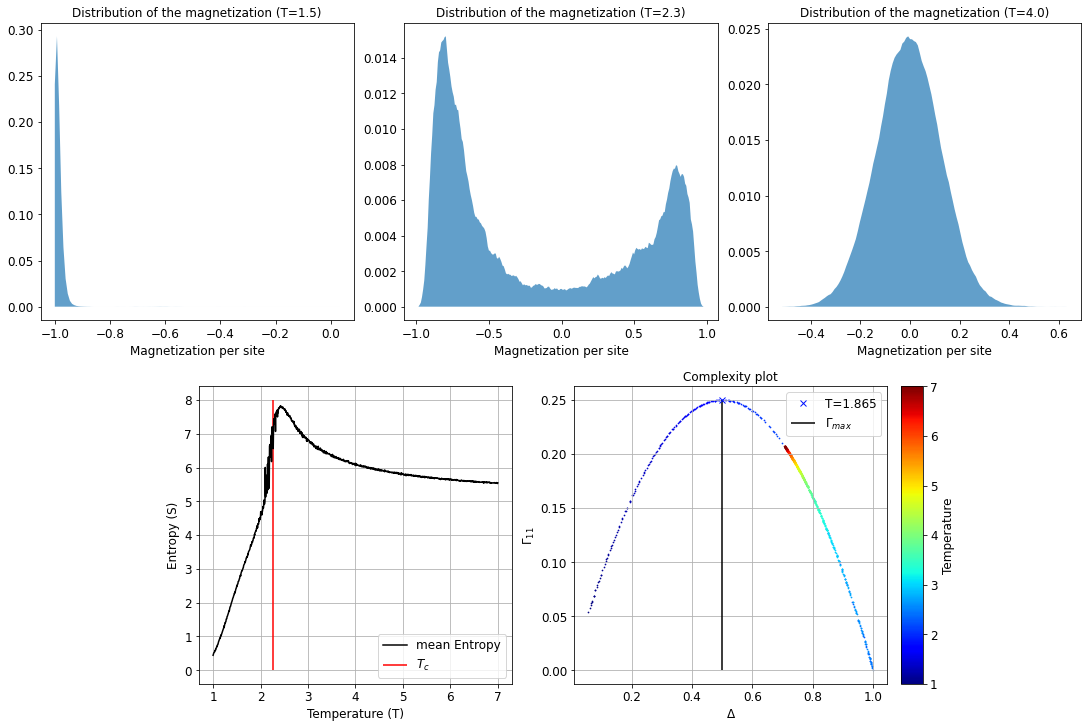

In [100]:
fig = plt.figure(figsize=(15,10), constrained_layout=True)

gs = plt.GridSpec(2,6, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

axs = [ax1, ax2, ax3]
for ax, m, T in zip(axs, [m1, m2, m3], [1.5,2.3,4.]):
    x, f = np.unique(m, return_counts=True)
    zeros = np.zeros(len(x))
    ax.fill_between(x, f / f.sum(), zeros, alpha=0.7)
    ax.set_xlabel('Magnetization per site')
    ax.set_title(f'Distribution of the magnetization (T={T})')

    
T = np.load('entropy.npz')['T']
E = np.load('entropy.npz')['E']
delta = np.load('entropy.npz')['delta']
gamma = np.load('entropy.npz')['gamma']

ax4.plot(T, E, 'k', label='mean Entropy')
ax4.vlines(2/(np.log(1+np.sqrt(2))), 0,8, color='r', label=r'$T_c$')
ax4.legend(loc='lower right')
ax4.set_xlabel('Temperature (T)')
ax4.set_ylabel('Entropy (S)')
ax4.grid()

normalize = mcolors.Normalize(vmin=T.min(), vmax=T.max())
colormap = cm.jet

for x,y,z in zip(delta,gamma,T):
    # setting rgb color based on z normalized to my range
    '''r = (float(z)-1.0)/(7.0-1.0)
    g = 1-r
    b = 0'''
    if y == gamma.max():
        ax5.plot(x,y,'x', color=colormap(normalize(z)), label=f'T={z:.3f}')
        ax5.vlines(x, 0,y, color='k', label=r'$\Gamma_{max}$')
    else:
        ax5.scatter(x,y,color=colormap(normalize(z)), s=0.5)
    

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(T)
cbar = plt.colorbar(scalarmappaple)

ax5.legend()
cbar.ax.set_ylabel('Temperature')
ax5.set_xlabel(r'$\Delta$')
ax5.grid()
ax5.set_ylabel(r'$\Gamma_{11}$')
ax5.set_title(r'Complexity plot')

plt.savefig('Images/2_slide.png')

In [38]:
def entr_mean(T):
    if T < 2.0:
        Mcsteps = 30 * L ** 2
        tmp = cold_config
    elif T > 3.0:
        Mcsteps = 30 * L ** 2
        tmp = hot_config
    else: 
        Mcsteps = 1000 * L ** 2
        tmp = cold_config
        
    w = np.zeros(18)
    w[np.arange(-8,9,4)+8] = np.exp(- np.arange(-8, 9, 4) / T)
    
    E = 0
    for r in range(100):
        config = tmp(L)
        
        for i in range(Mcsteps):
            MC_step_single(config, 1./T)
        
        x, p = np.unique(config, return_counts=True)
        p = p / (L*L)
        e = 0
        for i, j in zip(x, p):
            e -= j*np.log2(j)
        E += e
    
    return E / 100

In [9]:
%%time
L = 64
H = 0.
J = 1

entr_mean(2.3)

CPU times: user 2min 27s, sys: 797 ms, total: 2min 28s
Wall time: 2min 28s


0.871661381258196

In [14]:
%%time
L = 64
H = 0.
J = 1

t = np.linspace(1.0, 7.0, 1000)
#E = np.zeros(1000)
'''try:
    tot = np.load('entropies.npy')
except:
    tot = np.zeros((1000, len(t)))'''
    
'''p = Pool(cpu_count()-2)
tot = np.vstack((tot, p.map(entr_mean, t)))
p.close()'''


'''p = Pool(cpu_count()-2)
E[(t < 2.0) | (t > 3.0)] = p.map(entr_mean, t[(t < 2.0) | (t > 3.0)])
p.close()'''

p = Pool(cpu_count()-2)
E[(t > 2.0) & (t <= 3.0)] = p.map(entr_mean, t[(t > 2.0) & (t <= 3.0)])
p.close()

# nearly three hours

CPU times: user 750 ms, sys: 625 ms, total: 1.38 s
Wall time: 2h 10min 19s


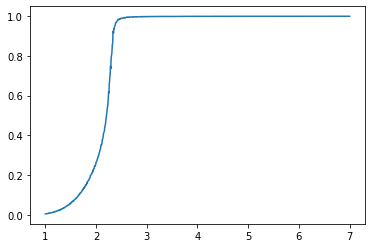

In [15]:
plt.plot(t, E)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(1.5,2.9)

In [32]:
t[np.argmax(E)]

2.423423423423423

In [16]:
d = E      # disorder grade
o = 1 - E  # order grade
c = d * o  # complexity grade
t[np.argmax(c)]

2.2072072072072073

## Kullback-Leibler distance

In [12]:
from scipy.stats import entropy

def pr(arr):
    n_arr = len(arr)
    value,counts = np.unique(arr, return_counts=True)
    probs = counts / n_arr
    n_classes = np.count_nonzero(probs)
    return probs

In [22]:
f1 = hist1[0]
f2 = hist2[0]
p = f1 / np.sum(f1)
q = f2 / np.sum(f2)
0.5 * (entropy(p[:], q) + entropy(q, p[:]))

0.18081040630625922

In [26]:
f1 = hist1[0]
f2 = hist3[0]
p = f1 / np.sum(f1)
q = f2 / np.sum(f2)
0.5 * (entropy(p[:], q) + entropy(q, p[:]))

4.218620743008768